# Falicov-Kimball Model

In [232]:
using KadanoffBaym
using LinearAlgebra
using LsqFit
using JLD
using UnPack

using PyPlot
using PyCall
qt = pyimport("qutip")
np = pyimport("numpy")

font_size = 16
# font_size = 20

PyPlot.matplotlib.rc("text", usetex=true)
PyPlot.matplotlib.rc("font", family="serif", size=font_size)
PyPlot.matplotlib.rc("axes", labelsize=font_size)
PyPlot.matplotlib.rc("xtick.major", size=8)
PyPlot.matplotlib.rc("ytick.major", size=8)
PyPlot.matplotlib.rc("xtick.minor", visible=true, size=4)
PyPlot.matplotlib.rc("ytick.minor", visible=true, size=4)
PyPlot.matplotlib.rc("xtick", top=true, direction="inout")
PyPlot.matplotlib.rc("ytick", right=true, direction="inout")

## Model

### Non-Hermitian Hamiltonian:

$$
\begin{align}\begin{split}
    \hat{H} &= \varepsilon \left( f^{\dagger}_1 f^\phantom{\dagger}_1  +  f^{\dagger}_2 f^\phantom{\dagger}_2 \right) - J \left(c^{\dagger}_1 c^\phantom{\dagger}_2 + c^{\dagger}_2 c^\phantom{\dagger}_1\right) + U \left( f^{\dagger}_1 f^\phantom{\dagger}_1 c^{\dagger}_1 c^\phantom{\dagger}_1  +  f^{\dagger}_2 f^\phantom{\dagger}_2 c^{\dagger}_2 c^\phantom{\dagger}_2 \right)
\end{split}\end{align}
$$

$$
    G^>_{ij}(t, t') = -i \langle c^\phantom{\dagger}_i(t) c^{\dagger}_j(t') \rangle\\
    F^>_{ij}(t, t') = -i \langle f^\phantom{\dagger}_i(t) f^{\dagger}_j(t') \rangle
$$

$$
    \Sigma^{\mathrm{HF}}_{c,\,ij}(t, t') = {\mathrm{i}}\delta_{ij}\delta(t - t') F^<_{ii}(t, t)\\
    \Sigma^{\mathrm{HF}}_{f,\,ij}(t, t') = {\mathrm{i}}\delta_{ij}\delta(t - t') G^<_{ii}(t, t)
$$

Not yet any guarantee for the prefactors!
$$
    \Sigma^{\mathrm{NCA}}_{c,\,ij}(t, t') = {\mathrm{i}\cdot (-\mathrm{i}) \cdot 2 U^2} G_{ij}(t, t') F_{ij}(t, t') F_{ji}(t', t)\\
    \Sigma^{\mathrm{NCA}}_{f,\,ij}(t, t') = {\mathrm{i}\cdot (-\mathrm{i}) \cdot 2 U^2} F_{ij}(t, t') G_{ij}(t, t') G_{ji}(t', t)
$$

### Equations of motion

#### Vertical Time.

\begin{align}\begin{split}
    0 &= \begin{pmatrix}
    i \partial_t - \varepsilon_1  & -J \\
    -J & i \partial_t - \varepsilon_2
    \end{pmatrix} 
    \begin{pmatrix}
    G^<_{11} & G^<_{12} \\
    G^<_{21} & G^<_{22}
    \end{pmatrix}(t, t')  \\
    0 &= \begin{pmatrix}
    i \partial_t - \varepsilon_1  & -J \\
    -J & i \partial_t - \varepsilon_2
    \end{pmatrix} 
    \begin{pmatrix}
    G^>_{11} & G^>_{12} \\
    G^>_{21} & G^>_{22}
    \end{pmatrix}(t, t')   
\end{split}\end{align}

#### Horizontal Time.

\begin{align}\begin{split}
    0 &= \begin{pmatrix}
    G^<_{11} & G^<_{12} \\
    G^<_{21} & G^<_{22}
    \end{pmatrix}(t, t') 
    \begin{pmatrix}
    i \partial_{t'} + \varepsilon_1  & J \\
    J & i \partial_{t'} + \varepsilon_2
    \end{pmatrix}  \\
    0 &= \begin{pmatrix}
    G^>_{11} & G^>_{12} \\
    G^>_{21} & G^>_{22}
    \end{pmatrix}(t, t') 
    \begin{pmatrix}
    i \partial_{t'} + \varepsilon_1  & J \\
    J & i \partial_{t'} + \varepsilon_2
    \end{pmatrix}  
\end{split}\end{align}

#### Equal-Time.

\begin{align}\begin{split}
    0 &= i \partial_T
    \begin{pmatrix}
    G^<_{11} & G^<_{12} \\
    G^<_{21} & G^<_{22}
    \end{pmatrix}(T, 0)
    - \left[\begin{pmatrix}
    \varepsilon_1 & J \\
    J & \varepsilon_2
    \end{pmatrix}, 
    \begin{pmatrix}
    G^<_{11} & G^<_{12} \\
    G^<_{21} & G^<_{22}
    \end{pmatrix}(T, 0)\right]    \\
    0 &= i \partial_T
    \begin{pmatrix}
    G^>_{11} & G^>_{12} \\
    G^>_{21} & G^>_{22}
    \end{pmatrix}(T, 0)  
    - \left[\begin{pmatrix}
    \varepsilon_1 & J \\
    J & \varepsilon_2
    \end{pmatrix}, 
    \begin{pmatrix}
    G^>_{11} & G^>_{12} \\
    G^>_{21} & G^>_{22}
    \end{pmatrix}(T, 0)\right]
\end{split}\end{align}

## Solving

In [233]:
function integrate(x::AbstractVector, y::AbstractVector)
    if isone(length(x))
        return zero(first(y))
    end

    @inbounds retval = (x[2] - x[1]) * (y[1] + y[2])
    @inbounds @fastmath @simd for i in 2:(length(y) - 1)
        retval += (x[i+1] - x[i]) * (y[i] + y[i+1])
    end
    return 1//2 * retval
end;

In [234]:
# Self-energy
function self_energies!(nca, t, t′)
    @unpack GL, GG, FL, FG, ΣNCA_c_L, ΣNCA_c_G, ΣNCA_f_L, ΣNCA_f_G, U = nca
    
    if (n = size(GL, 3)) > size(ΣNCA_c_L, 3)
        resize!(ΣNCA_c_L, n)
        resize!(ΣNCA_c_G, n)
        resize!(ΣNCA_f_L, n)
        resize!(ΣNCA_f_G, n)        
    end
        
    ΣNCA_c_L[t, t′] = 0*1.0im * (-2.0im * U^2) * GL[t, t′] * FL[t, t′] * transpose(FG[t′, t])
    ΣNCA_c_G[t, t′] = 0*1.0im * (-2.0im * U^2) * GG[t, t′] * FG[t, t′] * transpose(FL[t′, t])
    
    ΣNCA_f_L[t, t′] = 0*1.0im * (-2.0im * U^2) * FL[t, t′] * GL[t, t′] * transpose(GG[t′, t])
    ΣNCA_f_G[t, t′] = 0*1.0im * (-2.0im * U^2) * FG[t, t′] * GG[t, t′] * transpose(GL[t′, t])
    
#     println(ΣNCA_f_L[t, t′])
end

# Container for non-crossing approximation
struct NCA
    GL::GreenFunction{ComplexF64, 4, Array{ComplexF64, 4}, Lesser}
    GG::GreenFunction{ComplexF64, 4, Array{ComplexF64, 4}, Greater}
    FL::GreenFunction{ComplexF64, 4, Array{ComplexF64, 4}, Lesser}
    FG::GreenFunction{ComplexF64, 4, Array{ComplexF64, 4}, Greater}
    ΣNCA_c_L::GreenFunction{ComplexF64, 4, Array{ComplexF64, 4}, Lesser}
    ΣNCA_c_G::GreenFunction{ComplexF64, 4, Array{ComplexF64, 4}, Greater}
    ΣNCA_f_L::GreenFunction{ComplexF64, 4, Array{ComplexF64, 4}, Lesser}
    ΣNCA_f_G::GreenFunction{ComplexF64, 4, Array{ComplexF64, 4}, Greater}
    
    U::Float64
  
    # Initialize problem
    function NCA(GL0::Matrix{ComplexF64}, FL0::Matrix{ComplexF64}, U::Float64)
        nca = new(
          GreenFunction(reshape(GL0, size(GL0)..., 1, 1), Lesser),
          GreenFunction(reshape(GL0 - 1.0im * I, size(GL0)..., 1, 1), Greater),
          GreenFunction(reshape(FL0, size(FL0)..., 1, 1), Lesser),
          GreenFunction(reshape(FL0 - 1.0im * I, size(FL0)..., 1, 1), Greater),            
          GreenFunction(zeros(ComplexF64, size(GL0)..., 1, 1), Lesser),
          GreenFunction(zeros(ComplexF64, size(GL0)..., 1, 1), Greater),
          GreenFunction(zeros(ComplexF64, size(FL0)..., 1, 1), Lesser),
          GreenFunction(zeros(ComplexF64, size(FL0)..., 1, 1), Greater),            
          U
        )

        # Initialize self-energies
        self_energies!(nca, 1, 1)

        return nca
    end
end

In [235]:
# final time
T = 5.0

# Hamiltonian
ε = 1.0
J = 1.0
H = ComplexF64[-J 0 0 0; 0 -J 0 0; 0 0 0 ε; 0 0 ε 0]
U = 0.5;

In [236]:
t_scale = J;

In [237]:
GL[1, 1] * FL[1, 1] * FL[1, 1]

2×2 Matrix{ComplexF64}:
 0.0-0.125im  0.0+0.0im
 0.0+0.0im    0.0+0.0im

In [238]:
# quantum numbers
dim = 2

# Define your Green functions at (t0, t0), time-arguments at the end!
GL0 = zeros(ComplexF64, dim, dim)
FL0 = zeros(ComplexF64, dim, dim)

# initial condition
N_c = 0.5
N_f = 1.0

GL0[1, 1] = 1.0im * N_c
GL0[2, 2] = 1.0im * 0.2
FL0[1, 1] = 1.0im * N_f
FL0[1, 1] = 1.0im * 0.5
# GG[:, :, 1, 1] = -1.0im .* diagm([1.0, 1.0]) .+ GL[:, :, 1, 1]
# FG[:, :, 1, 1] = -1.0im .* diagm([1.0, 1.0]) .+ FL[:, :, 1, 1]

# NCA data
nca = NCA(GL0, FL0, U);

u0 = [nca.GL, nca.GG, nca.FL, nca.FG] # [GL, GG, FL, FG]

function f_vert(nca, u, times, t, t′)
    
#     = u[1], u[2], u[3], u[4]
    @unpack GL, GG, FL, FG, ΣNCA_c_L, ΣNCA_c_G, ΣNCA_f_L, ΣNCA_f_G, U = nca
    
    # real-time collision integral
    ∫dt(i, j, A, B) = sign(j-i) * integrate(times[min(i, j):max(i, j)], 
                                          [A[t, t] .* B[t, t′] for t=min(i, j):max(i, j)])    
        
    # normal operator ordering
    ΣHF_c(t, t′) = 1.0im * U * [FL[1, 1, t, t] 0; 0 FL[2, 2, t, t]]
    ΣHF_f(t, t′) = 1.0im * U * [GL[1, 1, t, t] 0; 0 GL[2, 2, t, t]]
        
    f_GL = (- 1.0im * (H[1:2, 1:2] + ΣHF_c(t, t′)) * GL[t, t′] 
            - 1.0im * (∫dt(1, t, ΣNCA_c_G, GL) - ∫dt(1, t, ΣNCA_c_L, GL) + ∫dt(1, t′, ΣNCA_c_L, GL) - ∫dt(1, t′, ΣNCA_c_L, GG)))
    
    f_GG = (- 1.0im * (H[1:2, 1:2] + ΣHF_c(t, t′)) * GG[t, t′]
            - 1.0im * (∫dt(1, t, ΣNCA_c_G, GG) - ∫dt(1, t, ΣNCA_c_L, GG) + ∫dt(1, t′, ΣNCA_c_G, GL) - ∫dt(1, t′, ΣNCA_c_G, GG)))
    
    f_FL = (- 1.0im * (H[3:4, 3:4] + ΣHF_f(t, t′)) * FL[t, t′]
            - 1.0im * (∫dt(1, t, ΣNCA_f_G, FL) - ∫dt(1, t, ΣNCA_f_L, FL) + ∫dt(1, t′, ΣNCA_f_L, FL) - ∫dt(1, t′, ΣNCA_f_L, FG)))
    
    f_FG = (- 1.0im * (H[3:4, 3:4] + ΣHF_f(t, t′)) * FG[t, t′]
            - 1.0im * (∫dt(1, t, ΣNCA_f_G, FG) - ∫dt(1, t, ΣNCA_f_L, FG) + ∫dt(1, t′, ΣNCA_f_G, FL) - ∫dt(1, t′, ΣNCA_f_G, FG)))        
    
    return [f_GL, f_GG, f_FL, f_FG]
end

# f_diag = (u, times, t) -> f_vert(nca, u, times, t, t) - adjoint.(f_vert(nca, u, times, t, t));

function f_diag(u, times, t)
    println(" t: $(times[t])")
    return f_vert(nca, u, times, t, t) - adjoint.(f_vert(nca, u, times, t, t))
end;

In [239]:
# Basically this will mutate Lesser and Greater in place
sol = kbsolve((u, args...) -> f_vert(nca, u, args...), f_diag, u0, (0.0, T); 
              update_time = (_, args...) -> self_energies!(nca, args...), atol=1e-8, rtol=1e-6);

 t: 0.0
 t: 2.0e-7
 t: 2.0e-7
 t: 1.2e-6
 t: 1.2e-6
 t: 6.2e-6
 t: 6.2e-6
 t: 3.12e-5
 t: 3.12e-5
 t: 0.00015619999999999997
 t: 0.00015619999999999997
 t: 0.0007811999999999998
 t: 0.0007811999999999998
 t: 0.0013436999999999995
 t: 0.0013436999999999995
 t: 0.004156199999999998
 t: 0.004156199999999998
 t: 0.018218699999999987
 t: 0.018218699999999987
 t: 0.030874949999999977
 t: 0.030874949999999977
 t: 0.09415619999999991
 t: 0.09415619999999991
 t: 0.26944775979390023
 t: 0.26944775979390023
 t: 0.4272101636084105
 t: 0.4272101636084105
 t: 0.584487159169987
 t: 0.584487159169987
 t: 0.7260364551754057
 t: 0.7260364551754057
 t: 0.8629418897126777
 t: 0.8629418897126777
 t: 1.0030174831351044
 t: 1.0030174831351044
 t: 1.1290855172152885
 t: 1.1290855172152885
 t: 1.2711480672745006
 t: 1.2711480672745006
 t: 1.4341352048650902
 t: 1.4341352048650902
 t: 1.6029378023539422
 t: 1.6029378023539422
 t: 1.763940260729651
 t: 1.763940260729651
 t: 1.921227858989595
 t: 1.92122785898959

In [240]:
# stop = Int(n/2) + 1 

times = sol.t # range(0, length=n + 1, stop=T) |> collect;

n = length(sol.t) - 1

horizontal_times = k -> vcat(times[k:end] .- times[k], times[end] .+ (1:(k - 1) |> collect) .* (times[end] - times[end-1]));

In [241]:
n

44

## Example plots

In [242]:
GL, FL = nca.GL, nca.FL;

In [243]:
idx1 = 1
idx2 = 1;

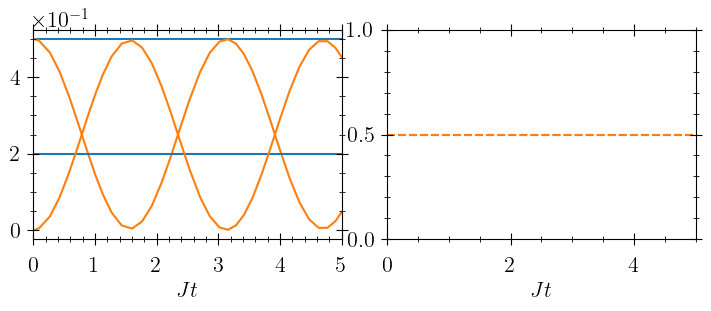

In [244]:
xpad = 8
ypad = 5

figure(figsize=(7, 3))

ax = subplot(121)
plot(J .* sol.t, [imag(GL.data[1, 1, k, k]) for k in 1:length(sol.t)], marker="", ms=3.0, ls="-", c="C0")
plot(J .* sol.t, [imag(FL.data[1, 1, k, k]) for k in 1:length(sol.t)], marker="", ms=3.0, ls="-", c="C1")
plot(J .* sol.t, [imag(GL.data[2, 2, k, k]) for k in 1:length(sol.t)], marker="", ms=3.0, ls="-", c="C0")
plot(J .* sol.t, [imag(FL.data[2, 2, k, k]) for k in 1:length(sol.t)], marker="", ms=3.0, ls="-", c="C1")


# plot(sol.t, [imag(gfL.data[2, 2, k, k]) for k in 1:length(sol.t)], marker="", ms=3.0, ls="-", c="r")
xlim(0, J * 5)
# ylim(0, 1)
xticks(J .* [0, 1, 2, 3, 4, 5])
# yticks([0, 0.5, 1])
xlabel("\$J t\$")
# ylabel("\$\\mathrm{Im}\\; G^<_{11}(t, t)\$")
ax.xaxis.set_tick_params(pad=xpad)
ax.yaxis.set_tick_params(pad=ypad)
ax.set_axisbelow(false)
ticklabel_format(axis="y", style="sci", scilimits=(-0, 0))

ax = subplot(122)
plot(J .* sol.t, [imag(GL.data[1, 1, k, k]) for k in 1:length(sol.t)], marker="", ms=3.0, ls="--", c="C0")
plot(J .* sol.t, [imag(FL.data[1, 1, k, k]) + imag(FL.data[2, 2, k, k]) for k in 1:length(sol.t)], marker="", ms=3.0, ls="--", c="C1")
xlim(0, J * 5)
# ylim(0, 1)
# xticks(J .* [0, 1, 2, 3, 4, 5])
yticks([0, 0.5, 1])
xlabel("\$J t\$")
# ylabel("\$\\mathrm{Im}\\left[ G^<_{11}(t, t) - \\mathcal{G}^<_{11}(t, t) \\right]\$", labelpad=16)
ax.xaxis.set_tick_params(pad=xpad)
ax.yaxis.set_tick_params(pad=ypad)
ax.yaxis.set_label_position("right")
ax.set_axisbelow(false)
# ax.yaxis.tick_right()
ticklabel_format(axis="y", style="sci", scilimits=(-0, 0))

tight_layout(pad=0.2, w_pad=0, h_pad=0)
# savefig("fermion_example_T.pdf")

## Testing

In [245]:
cmap = "gist_heat";

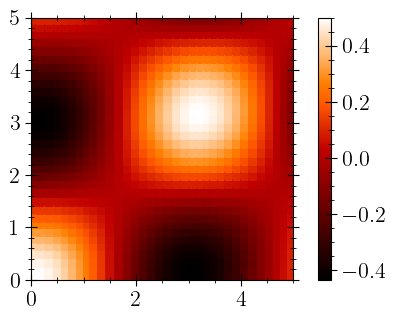

In [246]:
Y, X = np.meshgrid(sol.t, sol.t);
figure(figsize=(5, 3))
ax = plt.gca()
heatmap = ax.pcolormesh(t_scale * X, Y, imag(FL.data[1, 1, :, :]), cmap=cmap, rasterized=true) # vmin=vmin, vmax=vmax,
heatmap.set_edgecolor("face")
ax.set_aspect("equal")
# ax.set_xlabel("\$\\lambda T\$")
# ax.set_ylabel("\$\\omega\$")
# ax.set_xlim(0, t_scale * T)
# ax.set_xticks([0, t_scale * T/2, t_scale * T])
# ax.set_yticks([-20, -10, 0, 10, 20])
# ax.set_ylim(-20, 20)
colorbar(mappable=heatmap)
tight_layout(pad=0.0, w_pad=0, h_pad=0)